In [1]:
import pefile
import os
import re
import magic
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

## Generando Data set

In [66]:
path = "MALWR"
files = os.listdir(path)
print(files)

['POL55_A4F1ECC4D25B33395196B5D51A06790', 'KLp90_6D5C8FC4B14559F73B6136D85B94198', '8442AE37B91F279A9F06DE4C60B286A3', '65018CD542145A3792BA09985734C12A', 'PL98_BD8B082B7711BC980252F988BB0CA936', '650A6FCA433EE243391E4B4C11F09438', 'DS22_A670D13D4D014169C4080328B8FEB86', 'NV99_C9C9DBF388A8D81D8CFB4D3FC05F8E4', 'FGTR43_EF8E0FB20E7228C7492CCDC59D87C690', 'EEE99EC8AA67B05407C01094184C33D2B5A44', 'BVJ2D9FBF759F527AF373E34673DC3ACA462', 'FTTR9EA3C16194CE354C244C1B74C46CD92E', 'B98hX8E8622C393D7E832D39E620EAD5D3B49', 'SAM_B659D71AE168E774FAAF38DB30F4A84', 'B07322743778B5868475DBE66EEDAC4F', '6FAA4740F99408D4D2DDDD0B09BBDEFD', 'QW2_4C6BDDCCA2695D6202DF38708E14FC7E', '33DE5067A433A6EC5C328067DC18EC37', '1F2EB7B090018D975E6D9B40868C94CA', '99A39866A657A10949FCB6D634BB30D5', 'GFT4_7DDD3D72EAD03C7518F5D47650C8572', 'VC990_468FF2C12CFFC7E5B2FE0EE6BB3B239E', 'F6655E39465C2FF5B016980D918EA028', 'HJGQDD892986B2249B5214639ECC8AC0223', 'RTC_7F85D7F628CE62D1D8F7B39D8940472', 'TG78Z__727A6800991EEAD454E5

In [67]:
class PEFile:
    #Esta calse servira para guardar informacion interesante de los archivos
    
    def __init__(self, filename):

        self.pe = pefile.PE(filename, fast_load=True)
        
        self.filename = filename      
        self.DebugSize = self.pe.OPTIONAL_HEADER.DATA_DIRECTORY[6].Size
        self.DebugRVA = self.pe.OPTIONAL_HEADER.DATA_DIRECTORY[6].VirtualAddress
        self.ImageVersion = self.pe.OPTIONAL_HEADER.MajorImageVersion
        self.OSVersion = self.pe.OPTIONAL_HEADER.MajorOperatingSystemVersion
        self.ExportRVA = self.pe.OPTIONAL_HEADER.DATA_DIRECTORY[0].VirtualAddress
        self.ExportSize = self.pe.OPTIONAL_HEADER.DATA_DIRECTORY[0].Size
        self.IATRVA = self.pe.OPTIONAL_HEADER.DATA_DIRECTORY[12].VirtualAddress
        self.ResSize = self.pe.OPTIONAL_HEADER.DATA_DIRECTORY[2].Size
        self.LinkerVersion = self.pe.OPTIONAL_HEADER.MajorLinkerVersion
        self.NumberOfSections = self.pe.FILE_HEADER.NumberOfSections
        self.StackReserveSize = self.pe.OPTIONAL_HEADER.SizeOfStackReserve
        self.Dll = self.pe.OPTIONAL_HEADER.DllCharacteristics
        self.AddressOfEntryPoint = self.pe.OPTIONAL_HEADER.AddressOfEntryPoint
        self.ImageBase = self.pe.OPTIONAL_HEADER.ImageBase
        
        # If the PE file was loaded using the fast_load=True argument, we will need to parse the data directories:
        self.pe.parse_data_directories()
        imported_dll = {}
        number_dll = 0
        try:
            for entry in self.pe.DIRECTORY_ENTRY_IMPORT:
                if entry is not None:
                    number_dll += 1
                    for imp in entry.imports:
                        if imp.name is not None:
                            imported_dll[entry.dll.decode()] = imp.name.decode()
        except:
            pass
                        
        self.ImportedDLL = imported_dll
        self.NumberOfImportDLL = number_dll
        
        section_names = {}
        number_sections = 0
        try:
            for section in self.pe.sections:
                number_sections += 1
                section_names[section.Name.decode()] = section.SizeOfRawData
            self.SectionNames = section_names
            self.NumberOfSections = number_sections
        except:
            pass
            
        number_import_functions = 0
        import_function = []
        
        try:
            if self.pe.OPTIONAL_HEADER.DATA_DIRECTORY[pefile.DIRECTORY_ENTRY['IMAGE_DIRECTORY_ENTRY_IMPORT']].VirtualAddress != 0:
                self.pe.parse_data_directories(directories=[pefile.DIRECTORY_ENTRY['IMAGE_DIRECTORY_ENTRY_IMPORT']])
                for entry in self.pe.DIRECTORY_ENTRY_IMPORT:
                    for imp in entry.imports:
                        if imp.name:
                            number_import_functions += 1
                            import_function.append(imp.name.decode())
        except:
            pass
            
        self.NumberOfImportFunctions = number_import_functions
        self.ImportedFunctions = import_function
        
    def Construct(self):
        sample = {}

        for attr, k in self.__dict__.items():
            if(attr != "pe"):
                sample[attr] = k
        return sample
    

In [68]:
def pe2vec(directory):
    """
    dirty function (handling all exceptions) for each sample
    it construct a dictionary of dictionaries in the format:
    sample x : pe informations
    """
    dataset = {}
    print("")
    print("[*] Extracting the PE file data: ")
    print("")
    for subdir, dirs, files in os.walk(directory):
        for f in files:
            file_path = os.path.join(subdir, f)
            
            if re.match('^PE.*', magic.from_file(file_path)):
                try:
                    pe = PEFile(file_path)
                    dataset[str(f)] = pe.Construct()
                except Exception as e:
                    raise
            else:
                os.remove(file_path)
    return dataset

In [69]:
dsmalware = {}
dsmalware = pe2vec(path)


[*] Extracting the PE file data: 



In [70]:
def vec2csv(dataset, output_file):
    df = pd.DataFrame(dataset)
    test_data = df.transpose() 
    test_data.to_csv(output_file,sep=',', encoding='utf-8')
    print("")
    print("[+] Saving file to: " + output_file)
    print("")
        

In [71]:
output= "./malware.csv"
vec2csv(dsmalware, output)


[+] Saving file to: ./malware.csv



## EDA

In [2]:
df = pd.read_csv("./malware.csv")

In [3]:
df.shape

(40, 21)

In [4]:
df.head()

,Unnamed: 0,filename,DebugSize,DebugRVA,ImageVersion,OSVersion,ExportRVA,ExportSize,IATRVA,ResSize,...,NumberOfSections,StackReserveSize,Dll,AddressOfEntryPoint,ImageBase,ImportedDLL,NumberOfImportDLL,SectionNames,NumberOfImportFunctions,ImportedFunctions
0,POL55_A4F1ECC4D25B33395196B5D51A06790,MALWR/POL55_A4F1ECC4D25B33395196B5D51A06790,0,0,0,4,0,0,16384,0,...,3,1048576,0,3422617582,4194304,"{'KERNEL32.dll': 'CloseHandle', 'USER32.dll': ...",7,"{'.text\x00\x00\x00': 9728, '.rdata\x00\x00': ...",85,"['CreateFileA', 'LocalAlloc', 'Sleep', 'Create..."
1,KLp90_6D5C8FC4B14559F73B6136D85B94198,MALWR/KLp90_6D5C8FC4B14559F73B6136D85B94198,0,0,0,4,0,0,16384,0,...,3,1048576,0,3422617582,4194304,"{'KERNEL32.dll': 'CloseHandle', 'USER32.dll': ...",7,"{'.text\x00\x00\x00': 9728, '.rdata\x00\x00': ...",85,"['CreateFileA', 'LocalAlloc', 'Sleep', 'Create..."
2,8442AE37B91F279A9F06DE4C60B286A3,MALWR/8442AE37B91F279A9F06DE4C60B286A3,0,0,0,4,0,0,0,88,...,3,1048576,0,27632,4194304,"{'KERNEL32.DLL': 'VirtualProtect', 'MSVCRT.dll...",4,"{'UPX0\x00\x00\x00\x00': 0, 'UPX1\x00\x00\x00\...",7,"['LoadLibraryA', 'ExitProcess', 'GetProcAddres..."
3,65018CD542145A3792BA09985734C12A,MALWR/65018CD542145A3792BA09985734C12A,0,0,0,4,0,0,0,88,...,3,1048576,0,28048,4194304,"{'KERNEL32.DLL': 'VirtualProtect', 'MSVCRT.dll...",5,"{'UPX0\x00\x00\x00\x00': 0, 'UPX1\x00\x00\x00\...",8,"['LoadLibraryA', 'ExitProcess', 'GetProcAddres..."
4,PL98_BD8B082B7711BC980252F988BB0CA936,MALWR/PL98_BD8B082B7711BC980252F988BB0CA936,0,0,0,4,807356,176,0,0,...,3,1048576,0,804624,268435456,"{'ADVAPI32.dll': 'RegSaveKeyA', 'GDI32.dll': '...",8,"{'UPX0\x00\x00\x00\x00': 0, 'UPX1\x00\x00\x00\...",10,"['RegSaveKeyA', 'BitBlt', 'LoadLibraryA', 'Get..."


In [5]:
df.describe()

,DebugSize,DebugRVA,ImageVersion,OSVersion,ExportRVA,ExportSize,IATRVA,ResSize,LinkerVersion,NumberOfSections,StackReserveSize,Dll,AddressOfEntryPoint,ImageBase,NumberOfImportDLL,NumberOfImportFunctions
count,40.0,40.0,40.0,40.0,40.000000,40.000000,40.000000,40.000000,40.0,40.000000,40.0,40.0,4.000000e+01,4.000000e+01,40.000000,40.000000
mean,0.0,0.0,0.0,4.0,95031.900000,22.000000,3276.800000,191.100000,6.0,3.025000,1048576.0,0.0,6.848401e+08,3.722445e+07,5.875000,23.775000
std,0.0,0.0,0.0,0.0,255470.205254,58.948043,6637.088716,332.861394,0.0,0.158114,0.0,0.0,1.386328e+09,8.850283e+07,1.522271,31.027273
min,0.0,0.0,0.0,4.0,0.000000,0.000000,0.000000,0.000000,6.0,3.000000,1048576.0,0.0,2.763200e+04,4.194304e+06,4.000000,7.000000
25%,0.0,0.0,0.0,4.0,0.000000,0.000000,0.000000,0.000000,6.0,3.000000,1048576.0,0.0,2.806400e+04,4.194304e+06,5.000000,8.000000
50%,0.0,0.0,0.0,4.0,0.000000,0.000000,0.000000,88.000000,6.0,3.000000,1048576.0,0.0,2.806400e+04,4.194304e+06,5.000000,8.000000
75%,0.0,0.0,0.0,4.0,0.000000,0.000000,0.000000,88.000000,6.0,3.000000,1048576.0,0.0,2.042528e+06,4.194304e+06,7.000000,11.250000
max,0.0,0.0,0.0,4.0,807356.000000,176.000000,16384.000000,1032.000000,6.0,4.000000,1048576.0,0.0,3.422618e+09,2.684355e+08,9.000000,85.000000


In [6]:
df["NumberOfImportFunctions"].value_counts()

8     18
85     8
7      6
10     5
12     2
11     1
Name: NumberOfImportFunctions, dtype: int64

In [7]:
df.drop(["Unnamed: 0","filename","ImportedDLL","SectionNames","ImportedFunctions"],axis = 1, inplace= True)

In [8]:
df.head()

,DebugSize,DebugRVA,ImageVersion,OSVersion,ExportRVA,ExportSize,IATRVA,ResSize,LinkerVersion,NumberOfSections,StackReserveSize,Dll,AddressOfEntryPoint,ImageBase,NumberOfImportDLL,NumberOfImportFunctions
0,0,0,0,4,0,0,16384,0,6,3,1048576,0,3422617582,4194304,7,85
1,0,0,0,4,0,0,16384,0,6,3,1048576,0,3422617582,4194304,7,85
2,0,0,0,4,0,0,0,88,6,3,1048576,0,27632,4194304,4,7
3,0,0,0,4,0,0,0,88,6,3,1048576,0,28048,4194304,5,8
4,0,0,0,4,807356,176,0,0,6,3,1048576,0,804624,268435456,8,10


In [9]:
df.drop(["DebugSize","DebugRVA","ImageVersion","OSVersion","LinkerVersion","StackReserveSize","Dll"],axis =1, inplace = True)

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40 entries, 0 to 39
Data columns (total 9 columns):
 #   Column                   Non-Null Count  Dtype
---  ------                   --------------  -----
 0   ExportRVA                40 non-null     int64
 1   ExportSize               40 non-null     int64
 2   IATRVA                   40 non-null     int64
 3   ResSize                  40 non-null     int64
 4   NumberOfSections         40 non-null     int64
 5   AddressOfEntryPoint      40 non-null     int64
 6   ImageBase                40 non-null     int64
 7   NumberOfImportDLL        40 non-null     int64
 8   NumberOfImportFunctions  40 non-null     int64
dtypes: int64(9)
memory usage: 2.9 KB


In [30]:
for column in list(df.columns):
    print(df[column].value_counts())

0         35
807356     3
689604     2
Name: ExportRVA, dtype: int64
0      35
176     5
Name: ExportSize, dtype: int64
0        32
16384     8
Name: IATRVA, dtype: int64
88      21
0       13
908      3
1020     2
1032     1
Name: ResSize, dtype: int64
3    39
4     1
Name: NumberOfSections, dtype: int64
28064         12
3422617582     8
27632          6
28048          3
2042528        3
804624         2
775248         2
684768         1
614704         1
684672         1
804608         1
Name: AddressOfEntryPoint, dtype: int64
4194304      35
268435456     5
Name: ImageBase, dtype: int64
5    18
7     7
4     6
8     6
9     2
6     1
Name: NumberOfImportDLL, dtype: int64
8     18
85     8
7      6
10     5
12     2
11     1
Name: NumberOfImportFunctions, dtype: int64


Procedemos a ignorar las caracteristicas que poseem muchos valores similares

In [50]:
scaler = StandardScaler()
scaled_df = scaler.fit_transform(df[["NumberOfImportDLL","NumberOfImportFunctions", "ExportSize","AddressOfEntryPoint", "ResSize"]])

scaled_df

array([[ 0.74844237,  1.99840211, -0.37796447,  1.99999984, -0.58142667],
       [ 0.74844237,  1.99840211, -0.37796447,  1.99999984, -0.58142667],
       [-1.24740394, -0.54754096, -0.37796447, -0.50026885, -0.31368441],
       [-0.58212184, -0.51490067, -0.37796447, -0.50026855, -0.31368441],
       [ 1.41372447, -0.44962007,  2.64575131, -0.49970124, -0.58142667],
       [-0.58212184, -0.51490067, -0.37796447, -0.50026853, -0.31368441],
       [ 0.74844237,  1.99840211, -0.37796447,  1.99999984, -0.58142667],
       [ 0.74844237,  1.99840211, -0.37796447,  1.99999984, -0.58142667],
       [ 1.41372447, -0.44962007,  2.64575131, -0.4997888 ,  2.5219496 ],
       [-1.24740394, -0.54754096, -0.37796447, -0.50026885, -0.31368441],
       [-0.58212184, -0.51490067, -0.37796447, -0.50026853, -0.31368441],
       [-1.24740394, -0.54754096, -0.37796447, -0.50026885, -0.31368441],
       [ 1.41372447, -0.41697978, -0.37796447, -0.49983998, -0.58142667],
       [ 0.74844237,  1.99840211, -0.3

## Metodo del codo para identificar k

In [52]:
def calculate_WSS(points, kmax):
  sse = []
  for k in range(1, kmax+1):
    kmeans = KMeans(
        init = "random",
        n_clusters = k,
        n_init = 1,
        max_iter = 200,
        random_state = 123
    ).fit(points)
    centroids = kmeans.cluster_centers_
    pred_clusters = kmeans.predict(points)
    curr_sse = 0
    
    for i in range(len(points)):
      curr_center = centroids[pred_clusters[i]]
      curr_sse += (points[i, 0] - curr_center[0]) ** 2 + (points[i, 1] - curr_center[1]) ** 2
      
    sse.append(curr_sse)
  return sse

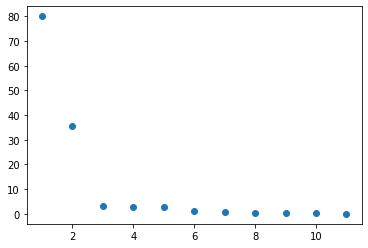

In [67]:
wss = calculate_WSS(scaled_df,11)
k = [1,2,3,4,5,6,7,8,9,10,11]
plt.scatter(k[:], wss[:])

In [63]:
from sklearn.metrics import silhouette_score

sil = []
kmax = 12

for k in range (2, kmax+1):
  kmeans = KMeans(
        init = "random",
        n_clusters = k,
        n_init = 1,
        max_iter = 200,
        random_state = 123
    ).fit(df.to_numpy())
  etiquetas = kmeans.labels_
  sil.append(silhouette_score(scaled_df, etiquetas, metric = 'euclidean'))

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]


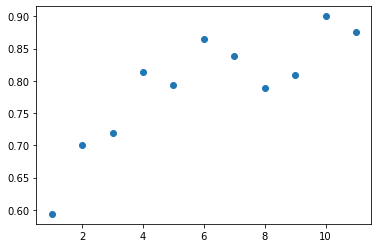

In [64]:
  k = [1,2,3,4,5,6,7,8,9,10,11]
  print(k)
 
  plt.scatter(k, sil)

## Kmeans con k = 10

In [56]:
kmeans = KMeans(
    init = "random",
    n_clusters = 10,
    n_init = 1,
    max_iter = 200,
    random_state = 123
)

In [57]:
kmeans.fit(scaled_df)

KMeans(init='random', max_iter=200, n_clusters=10, n_init=1, random_state=123)

In [58]:
y_kmeans = kmeans.predict(scaled_df)

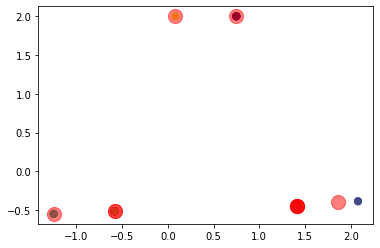

In [59]:
plt.scatter(scaled_df[:,0], scaled_df[:,1], c=y_kmeans, s=50, cmap='viridis')


centers = kmeans.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], c='red', s=200, alpha=0.5);


## Conclusiones

Como se puede apreciar el metodo del codo y el metodo de los coeficientes de sillhouete no tienen el mismo valor, el metodo del codo nos da un codo de 3 mientras que los coeficientes tienen un valor mas alto en 10, visto que analizar los resultados es dificil ya que estamos hablando de 5 dimensiones, se escogio entonces ir por el coeficiente de sillhouete ya que es un metodo mas confiable. Entonces concluimos que el conjunto tiene 10 tipos de malwares distintos